In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess


#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess


import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point

In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir


# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [4]:
# Load & squeeze
precip_hist = rxr.open_rasterio("precip_suitability_hist.tif").squeeze()
clay   = rxr.open_rasterio("clay_suitability.tif").squeeze()
sand   = rxr.open_rasterio("sand_suitability.tif").squeeze()
ph     = rxr.open_rasterio("ph_suitability.tif").squeeze()
elev   = rxr.open_rasterio("elev_suitability.tif").squeeze()

if not precip_hist.rio.crs:
    precip_hist = precip_hist.rio.write_crs("EPSG:4326")
    
#  Reproject to match precip
clay = clay.rio.reproject_match(precip_hist)
sand = sand.rio.reproject_match(precip_hist)
ph   = ph.rio.reproject_match(precip_hist)
elev = elev.rio.reproject_match(precip_hist)

# Ensure binary and combine
combined_hist = (
    (precip_hist == 1) &
    (clay == 1) &
    (sand == 1) &
    (ph == 1) &
    (elev == 1)
).astype("uint8")

# Save to GeoTIFF
combined_hist.name = "juniper_combined_suitability_hist"
combined_hist.rio.to_raster("juniper_suitability_combined_hist.tif")

print("Combined suitability saved as juniper_suitability_combined_hist.tif")

Combined suitability saved as juniper_suitability_combined_hist.tif


In [7]:
# Load & squeeze
precip_future = rxr.open_rasterio("precip_suitability_future.tif").squeeze()
clay   = rxr.open_rasterio("clay_suitability.tif").squeeze()
sand   = rxr.open_rasterio("sand_suitability.tif").squeeze()
ph     = rxr.open_rasterio("ph_suitability.tif").squeeze()
elev   = rxr.open_rasterio("elev_suitability.tif").squeeze()

if not precip_future.rio.crs:
    precip_future = precip_future.rio.write_crs("EPSG:4326")
    
#  Reproject to match precip
clay = clay.rio.reproject_match(precip_future)
sand = sand.rio.reproject_match(precip_future)
ph   = ph.rio.reproject_match(precip_future)
elev = elev.rio.reproject_match(precip_future)

# Ensure binary and combine
combined_future = (
    (precip_future == 1) &
    (clay == 1) &
    (sand == 1) &
    (ph == 1) &
    (elev == 1)
).astype("uint8")

# Save to GeoTIFF
combined_future.name = "juniper_combined_suitability_future"
combined_future.rio.to_raster("juniper_suitability_combined_future.tif")

print("Combined suitability saved as juniper_suitability_combined_future.tif")

Combined suitability saved as juniper_suitability_combined_future.tif


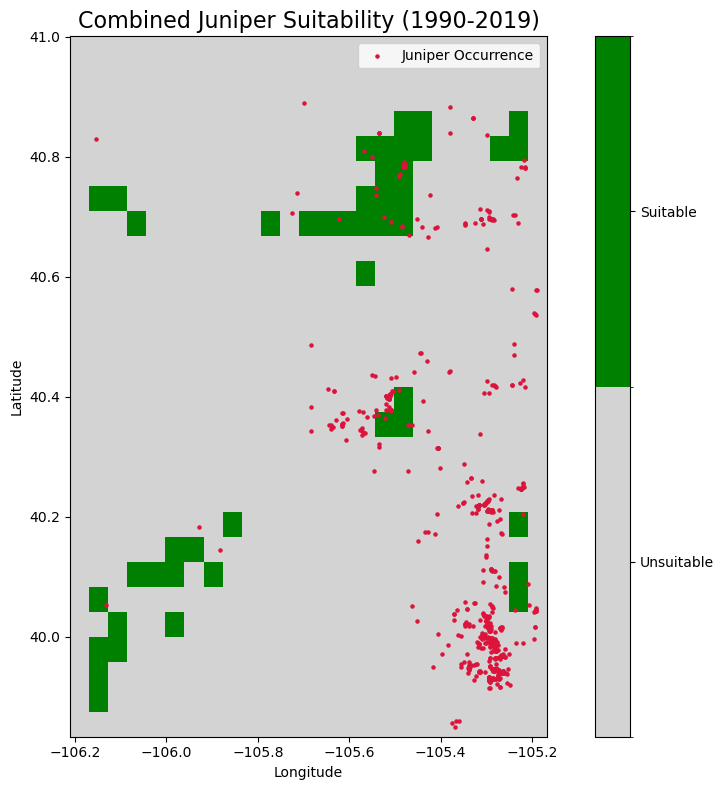

In [8]:
# Load combined suitability raster
combined_hist = rxr.open_rasterio("juniper_suitability_combined_hist.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))
im = combined_hist.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Labels and formatting
ax.set_title("Combined Juniper Suitability (1990-2019)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

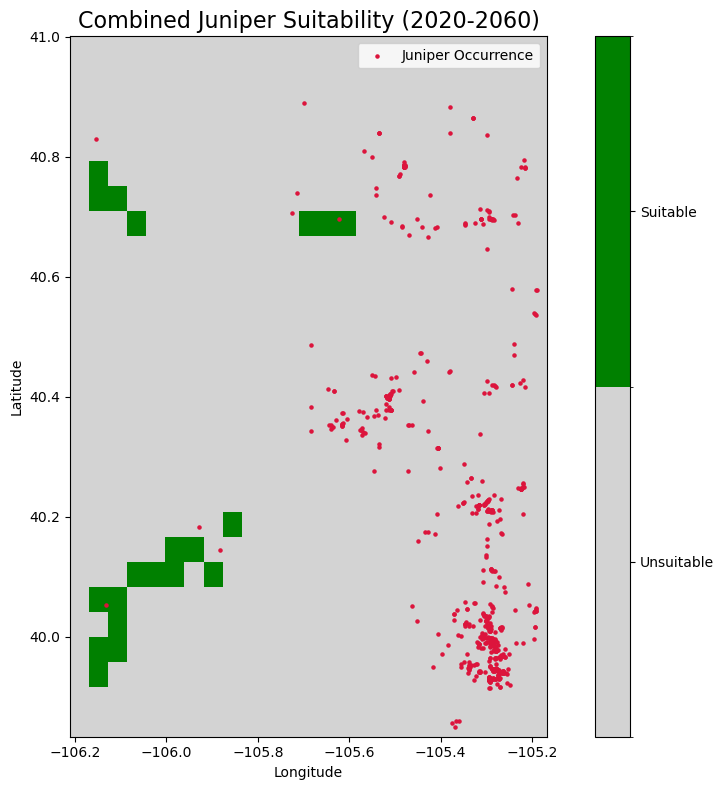

In [9]:
# Load combined suitability raster
combined_future = rxr.open_rasterio("juniper_suitability_combined_future.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))
im = combined_future.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Labels and formatting
ax.set_title("Combined Juniper Suitability (2020-2060)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(os.getcwd())
print(os.listdir())

In [ ]:
shapefile_gdf = gpd.read_file("zip://level3_ecoregion.zip")

# Load CSV (DataFrame)
csv_path = "~/data-store/CAST_Species_Test/Colorado_future_fires.csv"
csv_df = pd.read_csv(csv_path)

In [ ]:
shapefile_gdf = gpd.read_file("zip://level3_ecoregion.zip!us_eco_l3_state_boundaries.shp")

In [ ]:
print("Shapefile columns:\n", shapefile_gdf.columns)
print(shapefile_gdf.head())

print("\nCSV columns:\n", csv_df.columns)
print(csv_df.head())

In [ ]:
csv_avg = csv_df.groupby(['US_L3NAME', 'STATE_NAME'], as_index=False).agg({
    'En_NFire': 'mean',
    'En_BurnArea': 'mean'
})
joined_gdf = shapefile_gdf.merge(csv_avg, on=['US_L3NAME', 'STATE_NAME'], how='left')

In [ ]:
joined_gdf = shapefile_gdf.merge(csv_avg, on=['US_L3NAME', 'STATE_NAME'], how='left')

In [ ]:
joined_gdf.plot(
    column='En_NFire', 
    cmap='OrRd', 
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)
plt.title("Avg. Number of Fires by Ecoregion")
plt.axis('off')
plt.show()

In [ ]:
forest_gdf = forest_gdf.to_crs(joined_gdf.crs)

In [ ]:
roosevelt_clip = gpd.clip(joined_gdf, forest_gdf)

In [ ]:
roosevelt_clip.plot(
    column='En_NFire',
    cmap='OrRd',
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)
plt.title("Avg. Number of Fires by Ecoregion in Roosevelt National Forest")
plt.axis('off')
plt.show()

In [ ]:
roosevelt_clip.plot(
    ax=ax,
    column='En_NFire',
    cmap='OrRd',
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)

# Load combined suitability raster
combined = rxr.open_rasterio("juniper_suitability_combined.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(12, 8))
im = combined.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])


# Labels and formatting
ax.set_title("Combined Juniper Suitability (2005-2035)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("roosevelt_clip CRS:", roosevelt_clip.crs)

print("juniper_occur_gdf CRS:", juniper_occur_gdf.crs)

print("combined raster CRS:", combined.rio.crs)  # rio accessor if using rioxarray

# Check bounds of each dataset
print("roosevelt_clip bounds:", roosevelt_clip.total_bounds)  # (minx, miny, maxx, maxy)

print("juniper_occur_gdf bounds:", juniper_occur_gdf.total_bounds)

print("combined raster bounds:", combined.rio.bounds())  # returns (minx, miny, maxx, maxy)

# Optionally, check shapes and transforms for raster alignment
print("combined raster shape:", combined.shape)

print("combined raster transform:", combined.rio.transform())